# Calculating location misfit and plotting
This code goes through each event folders and reads event picks file (p(and/or s) wave arrival time) \ 
and calculated location for each event and plots given and calculated location side by side.\
It also uses parallel computing using 'ray' library for location calculation.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
nc73311641 ../data/eq_data/nc73311641/event_nc73311641_picks.txt


2023-12-28 03:52:16,019	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Best location and orign time estimates
lat:40.14, lon:-123.84, dep:25.50
Origin time:2019-12-04T19:40:13.477322Z


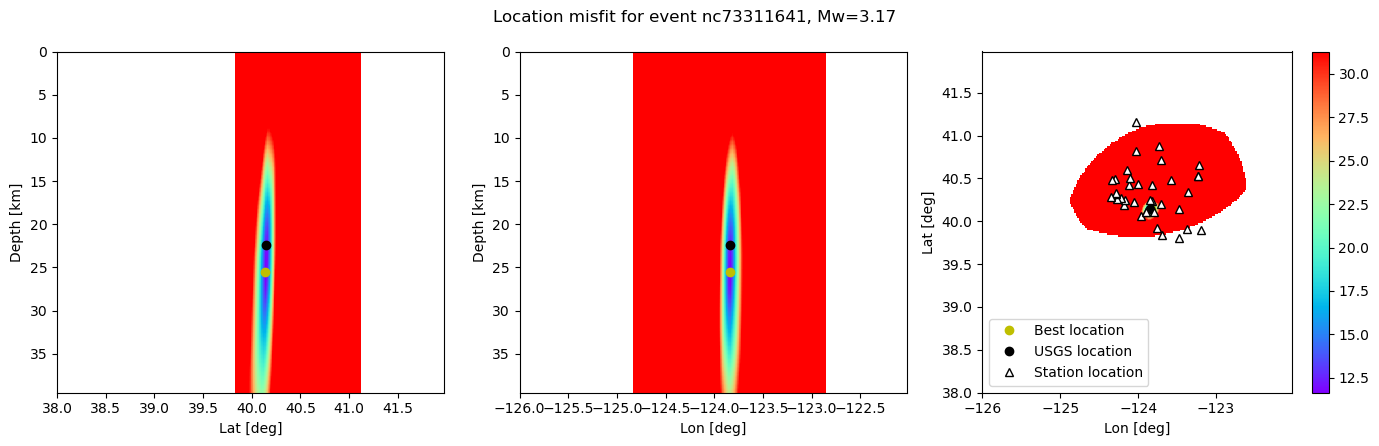

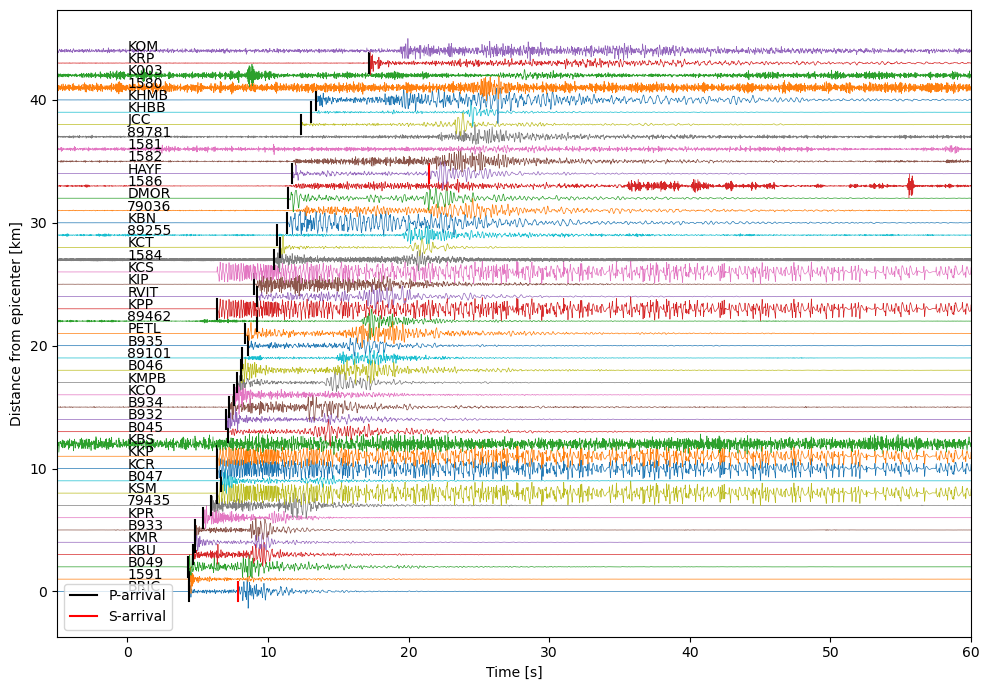

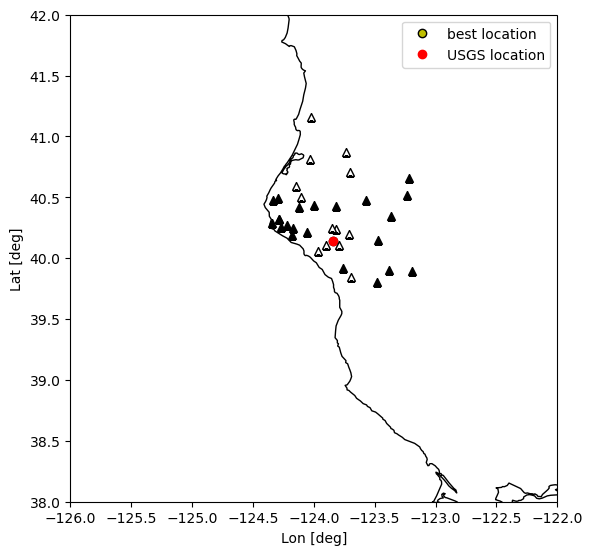

nc73629686 ../data/eq_data/nc73629686/event_nc73629686_picks.txt


2023-12-28 03:52:59,135	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Best location and orign time estimates
lat:40.24, lon:-124.16, dep:12.00
Origin time:2021-09-26T08:51:28.909060Z


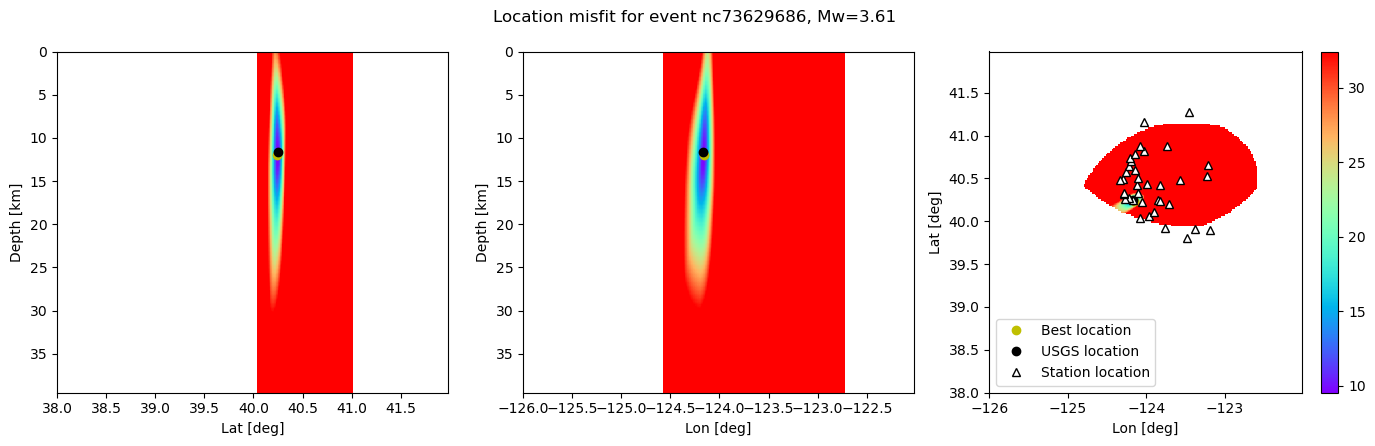

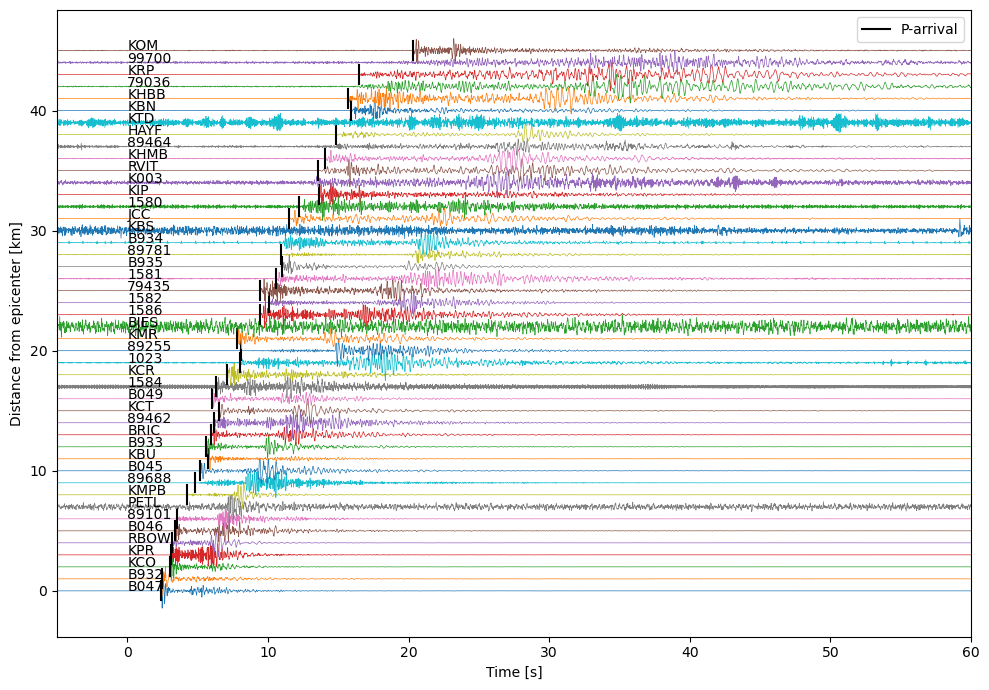

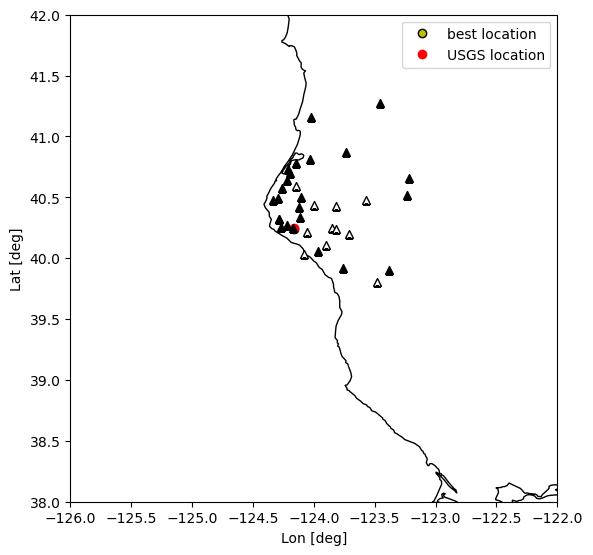

nc73783911 ../data/eq_data/nc73783911/event_nc73783911_picks.txt


2023-12-28 03:53:40,504	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Best location and orign time estimates
lat:39.94, lon:-123.28, dep:0.00
Origin time:2022-09-20T14:03:06.374578Z


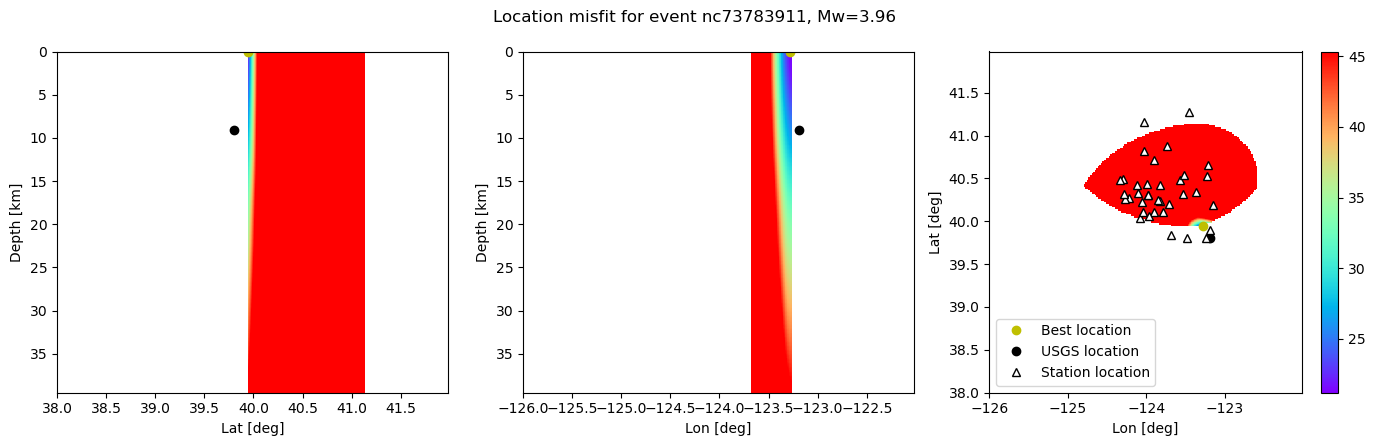

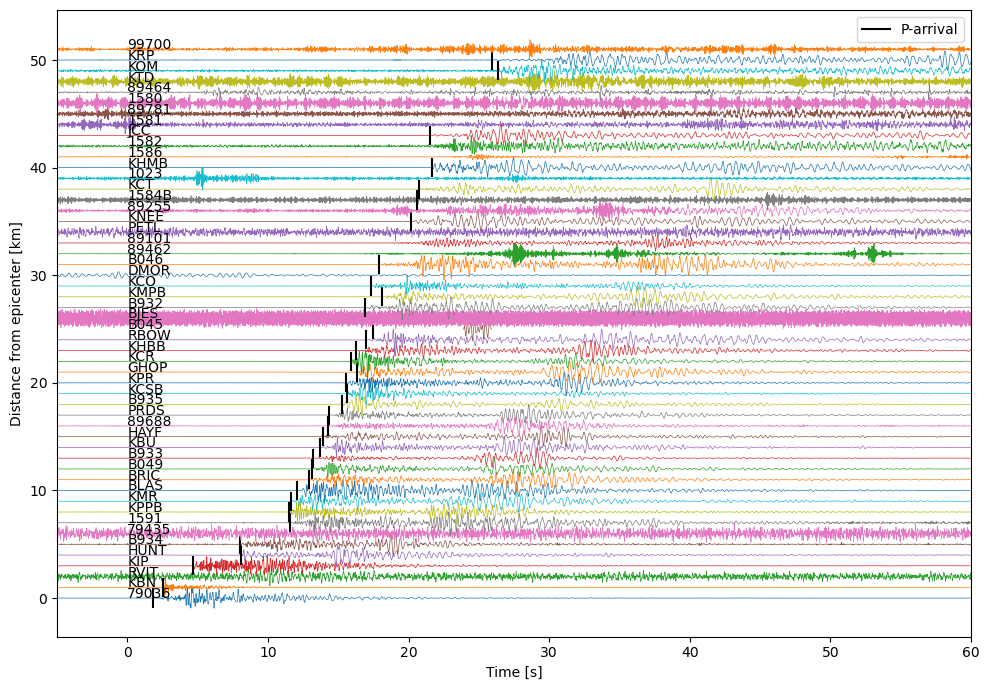

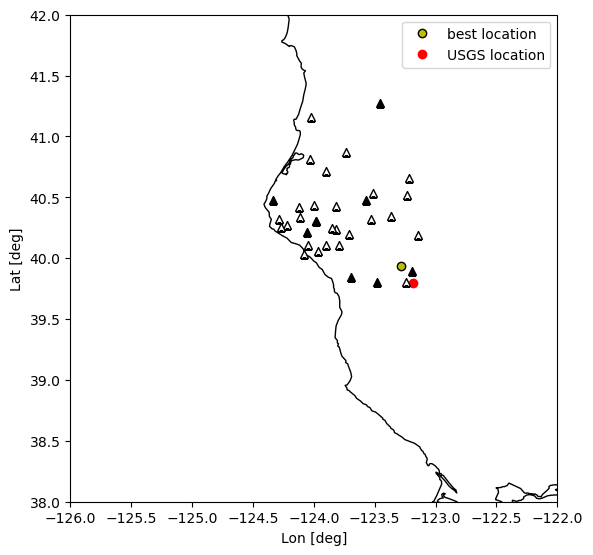

In [5]:
# reload the module to get the latest changes
import sys
sys.path.append('./my_funcs')
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import ray
# Initialize Ray (should be done once per notebook)
ignore_reinit_error=True
# ray.init()
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from my_funcs.step1_funcs import *
# # print the list of functions in step1_funcs.py, only that are defined in this file
# func_list = [func for func in dir() if callable(eval(func))]
# for f in func_list: print(f)

######### Part 1. Read phase picks #########
# get a list of all the event id folders
event_path = f"../data/eq_data/"
event_ids = [os.path.basename(event_id) for event_id in glob.glob(f"{event_path}*") if os.path.isdir(event_id)]
event_ids.sort()
# get the last 3 event ids
event_ids = event_ids[-3:]

# Read earthquake data
eqdf = pd.read_csv("../data/above_slab_eq_0.2_grid.csv", parse_dates=["time"])

######### define grids #########
lat_range = np.arange(38, 42, 0.02)
lon_range = np.arange(-126, -122, 0.02)
dep_range = np.arange(0, 40, 0.5)

########## Loop through all event folders ##########
for event_id in event_ids:
    
    folder_station = f'../data/eq_data/{event_id}'
    filename_picks = f'{folder_station}/event_{event_id}_picks.txt'
    print(event_id, filename_picks)

    ######### Part 1. Read phase picks #########
    # read phase picks file
    phasepicks, mean_arrival_time = read_phase_picks(filename_picks, folder_station)
    npick = phasepicks.shape[0]

    ######### Part 2. Points and value for P/S traveltime interpolation #########
    P_points, P_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_p')
    S_points, S_value = get_traveltime_points_value('./traveltime_point_values/tt_MTJ_comploc_s')

    ######### define grids #########
    # lat_range = np.arange(39.5, 41.5, 0.02)
    # lon_range = np.arange(-124.5, -123.0, 0.02)
    # dep_range = np.arange(0, 40, 0.5)
    nx, ny, nz = len(lon_range), len(lat_range), len(dep_range)

    event_df = eqdf[eqdf["id"] == event_id]
    elat, elon, edep, t_origin = event_df["latitude"].values[0], event_df["longitude"].values[0], event_df["depth"].values[0], UTCDateTime(pd.to_datetime(event_df["time"].values[0]))

    grids_lat, grids_lon, grids_z = np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, )), np.zeros((nx*ny*nz, ))
    for grid_index in range(0, nx*ny*nz):
        lon_index, lat_index, dep_index = np.unravel_index(grid_index, (nx, ny, nz)) 
        grids_lon[grid_index] = lon_range[lon_index]
        grids_lat[grid_index] = lat_range[lat_index]
        grids_z[grid_index] = dep_range[dep_index]
    grid_x, grid_y = convert_lat_lon_to_xy(grids_lat, grids_lon)


    ######### loops #########
    distance = np.zeros((nx*ny*nz, npick))
    traveltime = np.zeros((nx*ny*nz, npick))
    traveltime_demean = np.zeros((nx*ny*nz, npick))
    mean_traveltime = np.zeros((nx*ny*nz, ))
    misfit = np.zeros((nx*ny*nz, ))

    ######### Part 3. Interpolate P/S traveltime #########
    ######### using multiprocessing #########
    

    ####################### Define your worker function #######################
    @ray.remote
    def worker(ipick, phasepicks, grid_x, grid_y, P_points, P_value, grids_z):
        distance = np.sqrt((phasepicks[ipick, 0] - grid_x)**2 +
                            (phasepicks[ipick, 1] - grid_y)**2)
        xi = np.array([distance, grids_z]).T # .T is transpose, means (2, 1) -> (1, 2)
        if phasepicks[ipick, 2] == 1:
            return griddata(P_points, P_value, xi, method='linear')
        else:
            return griddata(S_points, S_value, xi, method='linear')
    ####################### End of worker function ###########################

    # Set number of workers (ideally, less than CPU cores)
    n_workers = max(1, 8)

    # Submit tasks to Ray actors
    futures = [worker.remote(ipick, phasepicks, grid_x, grid_y, P_points, P_value, grids_z) for ipick in range(npick)]

    # Collect results from multiple processes
    traveltime = ray.get(futures)

    # Remove None values (picks with incompatible phase type)
    traveltime = [result for result in traveltime if result is not None]

    # Convert to numpy array and transpose
    traveltime = np.array(traveltime).T

    # shutdown Ray (otherwise, it will keep running in the background)
    ray.shutdown()
    
    ################ Remove mean for traveltime array ################

    for grid_index in range(0, nx*ny*nz):
        
        traveltime_demean[grid_index, :] = traveltime[grid_index, :] - np.mean(traveltime[grid_index, :])
        misfit[grid_index] = get_misfit(traveltime_demean[grid_index, :], phasepicks[:,3])
        mean_traveltime[grid_index] = np.mean(traveltime[grid_index, :])

    # find the best location. get the index of the minimum misfit
    min_index = np.nanargmin(misfit) # index of the minimum misfit, nanargmin ignores nan values
    min_index_x, min_index_y, min_index_z = np.unravel_index(min_index, (nx, ny, nz))

    # best location and origin time estimates
    best_lon, best_lat, best_dep = lon_range[min_index_x], lat_range[min_index_y], dep_range[min_index_z]
    origin_time = mean_arrival_time - mean_traveltime[min_index]
    print('Best location and orign time estimates')
    print('lat:{:.2f}, lon:{:.2f}, dep:{:.2f}'.format(best_lat, best_lon, best_dep))
    print('Origin time:{}'.format(origin_time))

    # write the best location and origin time to a file
    with open(f'{folder_station}/best_location.txt', 'w') as f:
        f.write(f"event_id, lat, lon, dep, origin time \n{event_id}, {best_lat:.3f}, {best_lon:.3f}, {best_dep:.3f}, {origin_time}\n")


    ################### plot misfit ################### 
    png_folder = f'{folder_station}/png'
    if not os.path.exists(png_folder):
        os.mkdir(png_folder)

    slon, slat = get_sta_lat_lon(filename_picks, folder_station)

    # reshape misfit array to 3D
    misfit_matrix = np.reshape(misfit, (nx, ny, nz))
    vmin, vmax = np.nanmin(misfit), np.nanmax(misfit)
    vmax = (vmax - vmin) * 0.1 + vmin # set vmax to be 10% larger than the max value
    cmap = 'rainbow'

    fig = plt.figure(figsize=(14, 4.5))

    # N-S cross section
    ax = fig.add_subplot(1, 3, 1)
    i = min_index_x
    ax.imshow(
        misfit_matrix[i, :, :].T, 
        vmin=vmin, vmax=vmax, 
        origin='upper', cmap=cmap,
        extent=(lat_range[0], lat_range[-1], dep_range[-1], dep_range[0]), 
        aspect='auto'
        )
    # plot the best location
    ax.plot(grids_lat[min_index], grids_z[min_index], 'o', color='y')
    # plot the event location (given)
    ax.plot(elat, edep, 'o', color='black')
    ax.set_xlabel('Lat [deg]')
    ax.set_ylabel('Depth [km]')

    # E-W cross section
    ax = fig.add_subplot(1, 3, 2)
    i = min_index_y # index of the best lat
    ax.imshow(misfit_matrix[:, i, :].T, vmin=vmin, vmax=vmax, origin='upper', cmap=cmap,
            extent=(lon_range[0], lon_range[-1], dep_range[-1], dep_range[0]), aspect='auto')
    # plot the best location          
    ax.plot(grids_lon[min_index], grids_z[min_index], 'o', color='y')
    # plot the event location (given)
    ax.plot(elon, edep, 'o', color='black')
    ax.set_xlabel('Lon [deg]')
    ax.set_ylabel('Depth [km]')

    # Map view 
    ax = fig.add_subplot(1, 3, 3)
    i = min_index_z
    im = ax.imshow(misfit_matrix[:, :, i].T, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap,
            extent=(lon_range[0], lon_range[-1], lat_range[0], lat_range[-1]), aspect='auto')
    ax.plot(grids_lon[min_index], grids_lat[min_index], 'o', color='y') # best location
    ax.plot(elon, elat, 'o', color='black') # event location
    ax.plot(slon, slat, '^', color='w', mec='k') # station location

    # add figure labels, colorbar etc.
    fig.suptitle(f'Location misfit for event {event_id}, Mw={event_df["mag"].values[0]}')
    plt.colorbar(im)
    ax.set_xlabel('Lon [deg]')
    ax.set_ylabel('Lat [deg]')
    ax.legend(['Best location', 'USGS location', 'Station location'])
    plt.tight_layout()
    fig.savefig(f'{png_folder}/Misfit.png')
    plt.show()



    ################### plot waveform and picks ################### 
    phaselist = get_phasepicks_list(filename_picks)
    stanames, distances = get_sta_dist(folder_station, elat, elon)
    index = np.argsort(distances)
    mseed = f'{folder_station}/event_waveforms.mseed'
    st = read(mseed)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)

    for i in range(0, len(stanames)):
        j = index[i]
        sta = stanames[j]
        temp_st = st.select(station=sta)
        chans = []
        for k in range(0, len(temp_st)):
            chans.append(st[k].stats.channel)
            
        Z_channel = -1
        for k in range(0, len(chans)):
            if chans[k][-1] == 'Z':
                Z_channel = k
                break
        if Z_channel < 0:
            Z_channel = 0

        tr = temp_st[Z_channel]
        tr.detrend('demean')
        tr.filter('bandpass', freqmin=2, freqmax=20)
        tr.taper(0.05)
        tr.data = tr.data/np.max(tr.data) # normalize the waveform

        t = (tr.stats.starttime-t_origin) + np.arange(0, tr.stats.npts)/tr.stats.sampling_rate # time array
        # t = np.arange(0, tr.stats.npts)/tr.stats.sampling_rate + (tr.stats.starttime - t_origin)

        ax.plot(t, tr.data+i, lw=0.5) # plot waveform, lw is linewidth

        if '{}-P'.format(sta) in phaselist:

            dt = phaselist['{}-P'.format(sta)]-t_origin # time difference between origin time and P arrival time
            ax.plot([dt, dt], [i-0.8, i+0.8],'k', label='P-arrival' if i ==0 else None) # plot vertical line black for P arrival
        if '{}-S'.format(sta) in phaselist:
            dt = phaselist['{}-S'.format(sta)]-t_origin
            ax.plot([dt, dt], [i-0.8, i+0.8],'r', label='S-arrival' if i ==0 else None)
        ax.text(0, i, sta) # plot station name

    ax.legend()
    ax.set_xlim([-5, 60])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Distance from epicenter [km]')
    plt.tight_layout()
    fig.savefig(f'{png_folder}/picks.png')
    plt.show()


    ################### plot polarity ###################
    
    polarities, stanames = get_polarity(filename_picks, folder_station)

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()

    ax.plot(grids_lon[min_index], grids_lat[min_index], 'o', color='y', mec='k', label='best location') # best location
    ax.plot(elon, elat, 'o', color='r', label='USGS location') # event location
    for i in range(0, len(stanames)):
        if polarities[i, 0] == 1:
            ax.plot(polarities[i, 2], polarities[i, 1], '^', color='k', mec='k') # plot polarity black if positive
        elif polarities[i, 0] == -1:
            ax.plot(polarities[i, 2], polarities[i, 1], '^', color='w', mec='k')

    ax.set_xlim([lon_range[0], lon_range[-1]])
    ax.set_ylim([lat_range[0], lat_range[-1]])

    # Set custom tick locations and labels
    tick_interval = 0.5
    ax.set_xticks(np.arange(lon_range[0], lon_range[-1] + tick_interval, tick_interval), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_range[0], lat_range[-1] + tick_interval, tick_interval), crs=ccrs.PlateCarree())

    ax.set_xlabel('Lon [deg]')
    ax.set_ylabel('Lat [deg]')
    ax.legend()

    plt.tight_layout()
    fig.savefig(f'{png_folder}/Polarity.png')
    plt.show()
    plt.close('all')